In [1]:
%reload_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_AI4Top/Top-invar-DL'
GOOGLE_DRIVE_PATH = os.path.join(
    'drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import torch
if torch.cuda.is_available:
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Please set Gpu via Edit -> Notebook Setting')


Mounted at /content/drive
drive/My Drive/My_AI4Top/Top-invar-DL
Good to go


In [ ]:
!git clone --branch dev https://github.com/Junang-Wang/Top-invar-DL.git

(1, 2, 3, 1, 2, 3)

In [ ]:
del Graphene_params
del Graphene_SS_Gen



In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

2385239552

In [ ]:
from Graphene_Generator_v4_Gpu import *
torch.cuda.empty_cache()
device = 'cuda'
t = torch.arange(10,52,20)
#t = torch.tensor([16])
t_unique = t.shape[0]

Delta = 1
B_steps = 15
mu_steps = 15
mu_random = 11
B = torch.linspace(-2,2,B_steps)
mu_0 = torch.linspace(-5,5,mu_random).round(decimals=4)
mu_offset = torch.linspace(-2,2,mu_steps).round(decimals=4)
mu_truck = 1
mu_div = mu_random//mu_truck
nx, ny = 1500, 1500
Graphene_D = torch.zeros(t_unique,mu_random,mu_steps,B_steps)
for i in range(t_unique):
    for j in range(mu_div):
        Graphene_params = Graphene_Vec(t[i:i+1], mu_0[j*mu_truck:(j+1)*mu_truck], mu_offset, B, nx, ny, Delta, device='cuda')
        Graphene_SS_Gen = Graphene_SS(Graphene_params,device='cuda')
        Graphene_D[i,j*mu_truck:(j+1)*mu_truck] = Graphene_SS_Gen.total()
        del Graphene_params
        del Graphene_SS_Gen
        torch.cuda.empty_cache()
    if j == mu_div-1 and mu_random%mu_truck != 0:
        Graphene_params = Graphene_Vec(t[i:i+1], mu_0[(j+1)*mu_truck:], mu_offset, B, nx, ny, Delta, device='cuda')
        Graphene_SS_Gen = Graphene_SS(Graphene_params,device='cuda')
        Graphene_D[i,(j+1)*mu_truck:] = Graphene_SS_Gen.total()
        del Graphene_params
        del Graphene_SS_Gen
        torch.cuda.empty_cache()

label_mask = (abs(mu_0)<=2).repeat(t_unique)
Graphene_labels = label_mask*2*torch.ones(mu_random*t_unique)

Graphene_D = torch.pi/Delta*Graphene_D.reshape(t_unique*mu_random,1,B_steps,mu_steps)



/content/drive/My Drive/My_AI4Top/Top-invar-DL/Graphene_Generator_v4_Gpu.py:155: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "f" failed type inference due to: Untyped global name 'self': Cannot determine Numba type of <class 'Graphene_Generator_v4_Gpu.Graphene_SS'>

File "drive/My Drive/My_AI4Top/Top-invar-DL/Graphene_Generator_v4_Gpu.py", line 159:
        def f(y,x,t,mu,B):
            <source elided>
            v = np.cos(x)
            E_p = (np.sqrt((t*np.sqrt(4*(u*(u+v))+1)+1*mu)**2+self.Delta**2))
            ^

  @vectorize([float64(float64,float64,float64,float64,float64)])
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "f" was compiled in object mode without forceobj=True.

File "drive/My Drive/My_AI4Top/Top-invar-DL/Graphene_Generator_v4_Gpu.py", line 156:
        @vectorize([float64(float64,float64,float64,float64,float64)])
        def f(y,x,t,mu,B):
        ^


In [ ]:
Graphene_D = Graphene_D.reshape(3,11,15,15)
print(Graphene_D.shape)
print(Graphene_D.max())
print(Graphene_D.min())
#print(torch.argwhere(Graphene_D<-100))

torch.Size([3, 11, 15, 15])
tensor(7.1028)
tensor(-8.9027)


In [ ]:
Graphene_D = Graphene_D.reshape(21*101,1,15,15)

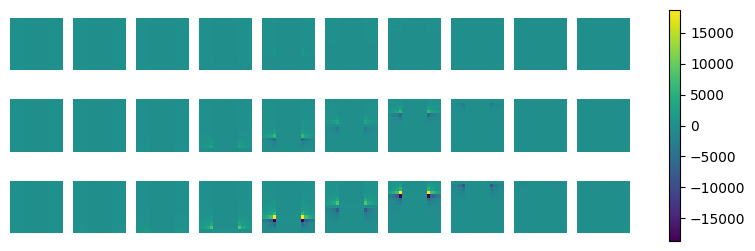

In [ ]:
import matplotlib.pyplot as plt
#t_unique = 21
t_unique = 3
mu_random = 11
Graphene_D = Graphene_D.reshape(t_unique,mu_random,15,15)
t_show = t_unique
mu_show = 10
fig, ax = plt.subplots(t_show,mu_show)
fig.set_figwidth(mu_show)
fig.set_figheight(t_show)

# vmax = 5
# vmin = -5
vmax = torch.max(Graphene_D).item()
vmin = torch.min(Graphene_D).item()
for i in range(t_show):
  for j in range(mu_show):
    im = ax[i,j].imshow(Graphene_D[i,j],vmax=vmax,vmin=vmin)
    #im = ax[j].imshow(Graphene_D[t_show*i,j],vmax=vmax,vmin=vmin)

    ax[i,j].axis('off')
    # if i == 0: #first row
    #   fig.text(i,j,f'{Graphene_labels[5*i*10*j,1].item():.1f}')
    # if j == 0: #first col:
    #   fig.text(i,j,f'{Graphene_labels[5*i*10*j,0].item():.1f}')

plt.colorbar(im,ax=ax)
plt.show()

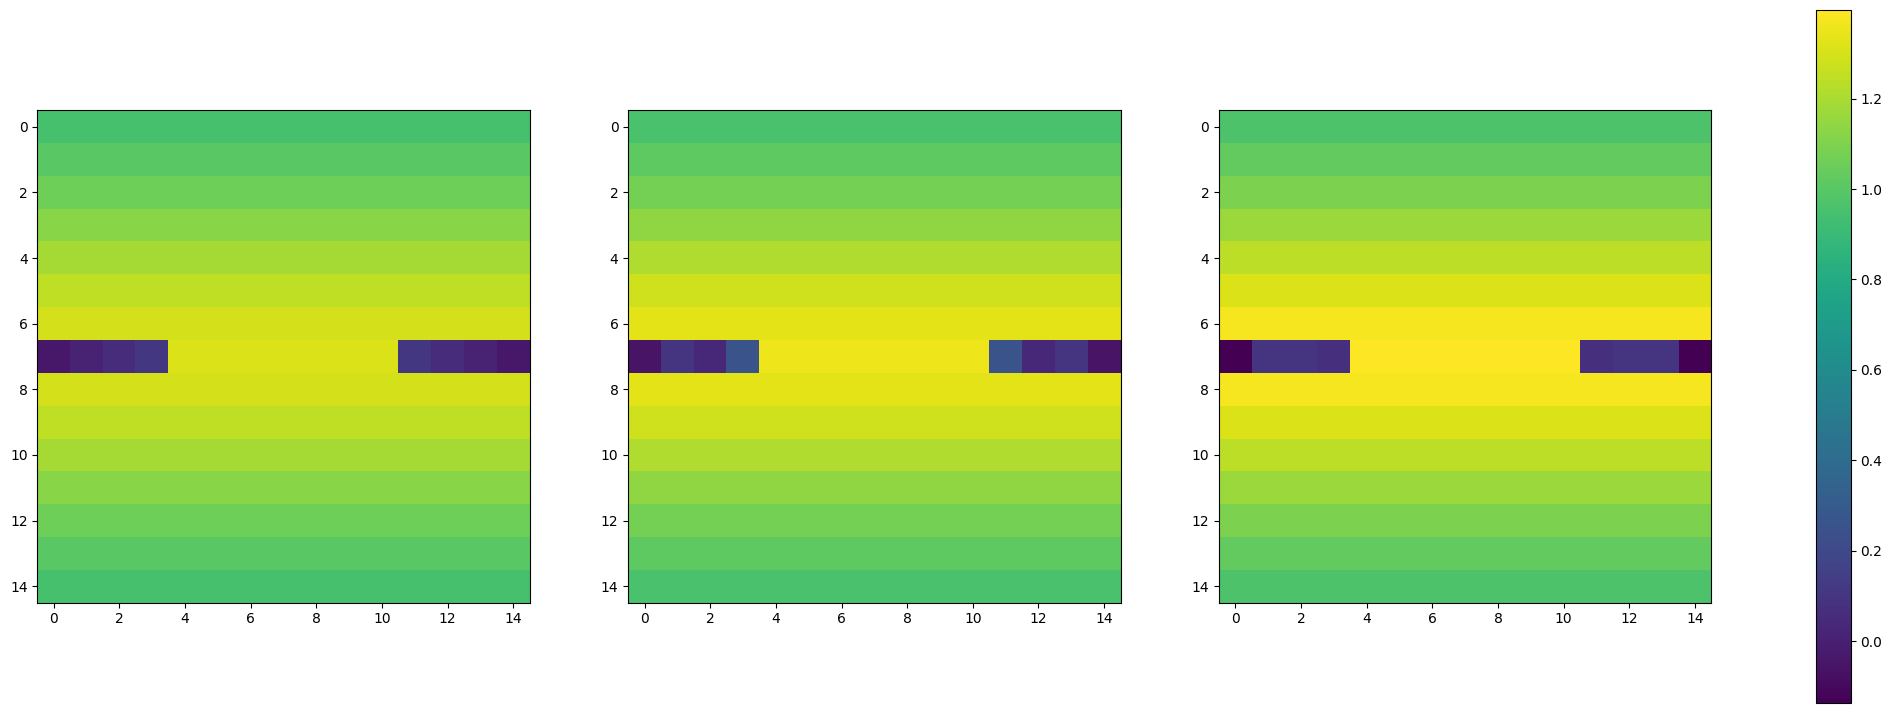

In [ ]:
fig,ax = plt.subplots(1,3)
fig.set_figwidth(27)
fig.set_figheight(9)
ax[0].imshow(Graphene_D[0,5],vmax=vmax,vmin=vmin)
ax[1].imshow(Graphene_D[1,5],vmax=vmax,vmin=vmin)
im=ax[2].imshow(Graphene_D[2,5],vmax=vmax,vmin=vmin)
plt.colorbar(im,ax=ax)

In [ ]:
print(D_total[1,5,7,7])

tensor(1.3333)


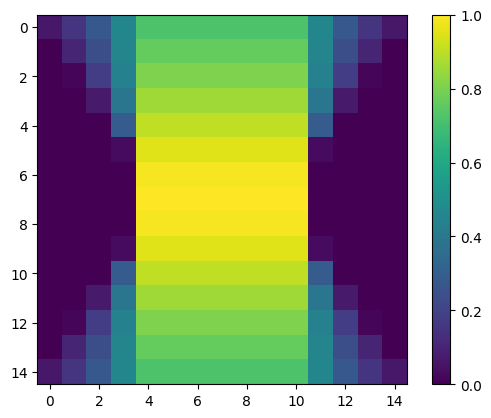

In [ ]:
plt.imshow(D_total[1,5])
plt.colorbar()

In [ ]:
D_total[1,5]

tensor([[0.0633, 0.1550, 0.2740, 0.4576, 0.7218, 0.7218, 0.7218, 0.7218, 0.7218,
         0.7218, 0.7218, 0.4576, 0.2740, 0.1550, 0.0633],
        [0.0000, 0.1018, 0.2406, 0.4548, 0.7630, 0.7630, 0.7630, 0.7630, 0.7630,
         0.7630, 0.7630, 0.4548, 0.2406, 0.1018, 0.0000],
        [0.0000, 0.0147, 0.1812, 0.4383, 0.8081, 0.8081, 0.8081, 0.8081, 0.8081,
         0.8081, 0.8081, 0.4383, 0.1812, 0.0147, 0.0000],
        [0.0000, 0.0000, 0.0729, 0.3942, 0.8565, 0.8565, 0.8565, 0.8565, 0.8565,
         0.8565, 0.8565, 0.3942, 0.0729, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2897, 0.9061, 0.9061, 0.9061, 0.9061, 0.9061,
         0.9061, 0.9061, 0.2897, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0276, 0.9523, 0.9523, 0.9523, 0.9523, 0.9523,
         0.9523, 0.9523, 0.0276, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9869, 0.9869, 0.9869, 0.9869, 0.9869,
         0.9869, 0.9869, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

In [ ]:
Graphene_D[0,5,7,7]

tensor(1.5120)

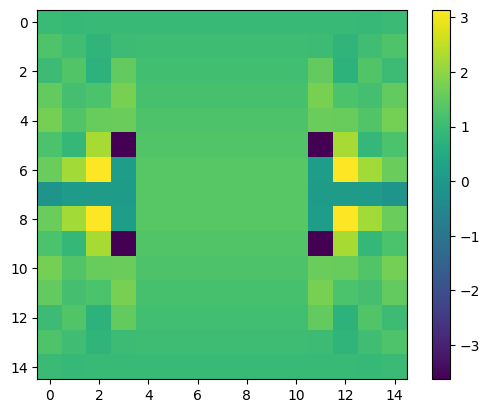

In [ ]:
plt.imshow(Graphene_D[2,5])
plt.colorbar()

t=500


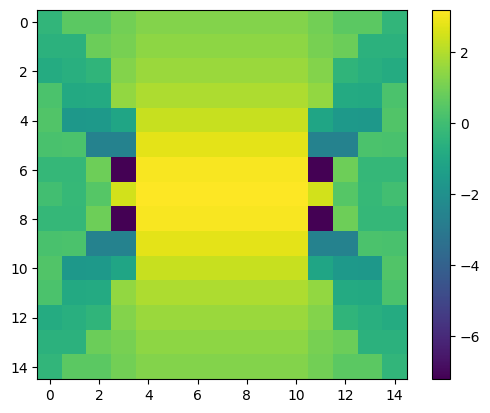

In [ ]:
print('t=500')
plt.imshow(Graphene_D[2,5])
plt.colorbar()

In [ ]:
Graphene_D_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_D.pt')
Graphene_label_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_label.pt')
torch.save(Graphene_D,Graphene_D_path)
torch.save(Graphene_labels,Graphene_label_path)

In [ ]:
%%time
from Dirac_model_analytic import *
#torch.set_printoptions(sci_mode=False)
device = 'cuda'
B_steps = 15
mu_steps = 15

winding_array = torch.tensor([2])
winding_unique = winding_array.shape[0]
Delta = torch.ones(1)
a_div_b = 1
B = torch.linspace(-2,2,steps=B_steps)
mu0 = torch.linspace(-5,5,11).round(decimals=4)
#mu0 = torch.tensor([0])
mu_offset_array = torch.linspace(-2,2,steps=mu_steps).round(decimals=4)
mu_random = mu0.shape[0]



'''
Compute Superfluid stiffness for each truck
'''
D_generator = Analytic_D(winding_array,mu0,mu_offset_array,B,device=device)
D_total = D_generator.total().to(device='cpu')
D_total_trivial = D_generator.trivial().to(device='cpu')
torch.cuda.empty_cache()

label_mask = (abs(mu0)<=2).repeat(winding_unique,1).reshape(-1,1)
labels = label_mask*(winding_array.repeat_interleave(mu_random).reshape(-1,1))
labels_trivial = torch.zeros(1,mu_random).reshape(-1,1)
# label_mask = (abs(mu0)<=2).repeat(winding_unique,1).reshape(-1,1)
# labels = torch.cat( (label_mask*(winding_array.repeat_interleave(mu_random).reshape(-1,1)),mu0.repeat(winding_unique).reshape(-1,1)),dim=1)
# labels_trivial = torch.cat((torch.zeros(1,mu_random).reshape(-1,1),mu0.reshape(-1,1)),dim=1)

D_total = torch.pi*torch.cat((D_total_trivial,D_total),dim=0)
labels = torch.cat((labels_trivial,labels),dim=0).reshape(-1)
print(D_total.shape)
print(labels.shape)

torch.Size([2, 11, 15, 15])
torch.Size([22])
CPU times: user 7.23 ms, sys: 2.07 ms, total: 9.3 ms
Wall time: 27.2 ms


tensor(3.5355) tensor(-3.6940)


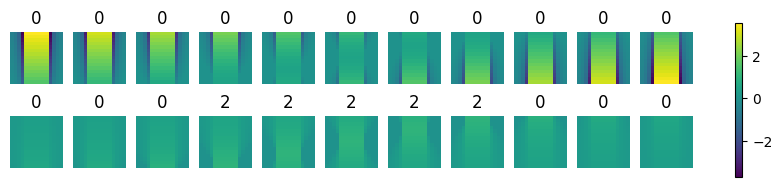

In [ ]:
import matplotlib.pyplot as plt
vmax = torch.max(D_total)
vmin = torch.min(D_total)
print(vmax,vmin)
D_total = D_total.reshape((winding_unique+1),mu_random,B_steps,mu_steps)
fig,ax = plt.subplots(winding_unique+1,mu_random)
fig.set_figwidth(mu_random)
fig.set_figheight(winding_unique+1)
#ax = ax.flatten()
vmax = torch.max(D_total)
vmin = torch.min(D_total)
for i in range((winding_unique+1)):
  for j in range(mu_random):
    #im = ax[i].imshow(D_total[i])
    im = ax[i,j].imshow(D_total[i,j],vmin=vmin,vmax=vmax)
    ax[i,j].set_title(f'{labels[i*mu_random+j].item():.0f}')
    ax[i,j].axis('off')
plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib
kx, ky = Graphene_params.kx.reshape(-1), Graphene_params.ky.reshape(-1)
#epsilon = Graphene_params.epsilon_0.reshape(nx, ny)
x, y = torch.meshgrid(kx, ky, indexing='ij')
#ax = plt.axes(projection='3d')
def plot_epsilon(t):
    epsilon = t*torch.sqrt(abs(3+2*torch.cos(sqrt(3)*y) + 4 *
                  torch.cos(sqrt(3)/2*y)*torch.cos(3/2*x)))
    masker_epsilon_cutoff = torch.zeros_like(epsilon)
    masker_epsilon_cutoff[epsilon <=1000] = 1

    masked_epsilon = masker_epsilon_cutoff*epsilon
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(x, y, masked_epsilon, cmap=matplotlib.cm.coolwarm)
    cset = ax.contourf(x,y,epsilon,zdir='z',offset = 0,cmap=matplotlib.cm.coolwarm)
    fig.colorbar(surf,ax=ax)
    plt.show()
    #ax.clear()



In [ ]:
%matplotlib widget
import ipywidgets
ipywidgets.interact(plot_epsilon,t=10000)
#plt.show()

interactive(children=(IntSlider(value=10000, description='t', max=30000, min=-10000), Output()), _dom_classes=…

<function __main__.plot_epsilon(t)>